# Homework 2: Titanic Machine Learning from Disaster

As described on the Kaggle website, the purpose of this project is to create a model that can accurately predict which passengers of the Titanic survived and which did not. To train and test our models, we have several variables that describe each passenger. These include the passenger's class aboard the ship, name, sex, age, number of siblings and spouses onboard, number of parents or children onboard, type of ticket, price of ticket, name of cabin, and port from which embarked.

We will evaluate our models based on several metrics, including accuracy, precision, recall, F1, and area under the ROC curve. We start by preparing our dataset as well as visualizing its content. We then train and evaluate several models.

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# We hide warnings to keep things pretty
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

Import Data

In [41]:
train_df = pd.read_csv("C:\\Users\\jacob\\Documents\\Datasets\\Homework4\\train.csv", header='infer')
test_df = pd.read_csv("C:\\Users\\jacob\\Documents\\Datasets\\Homework4\\test.csv", header='infer')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now we look at which variables have missing values. It looks like Age and Cabin have the most missing values. For the missing Embarked values in the Train dataset, we'll just fill in with 'S' which is the most common value. Since only two are missing, this shouldn't cause any problems. For the missing Fare in the Test datset, we fill in with the median Fare value of the Train datset.

In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train_df["Embarked"] = train_df["Embarked"].fillna("S")

In [6]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
test_df["Fare"].fillna(train_df["Fare"].median(), inplace=True)

We do some data visualization that will guide how we clean the data. This first graph shows that survival varies greatly by Pclass. We might want to consider including Pclass in our models, but only if we want our models to be any good.

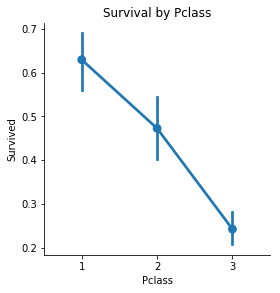

In [8]:
sns.factorplot('Pclass','Survived', order=[1,2,3], data=train_df,size=4)
plt.title("Survival by Pclass")
plt.show()

Similarly, Gender also has huge predictive power, something we'll be sure to keep in mind.

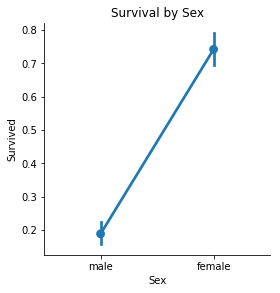

In [9]:
sns.factorplot('Sex','Survived', data=train_df,size=4)
plt.title("Survival by Sex")
plt.show()

In addition to looking at the average survival across different groups, it's also good to keep in mind how many femal vs male passengers there were. Here it's maybe even clearer how bad it was to be male.

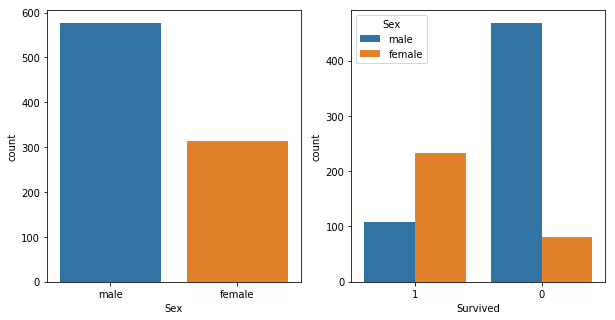

In [10]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Sex', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue="Sex", data=train_df, order=[1,0], ax=axis2)
plt.show()

Which port the passenger embarked from is also very important, with the odds of surviving being significantly higher if the passenger departed from "C".

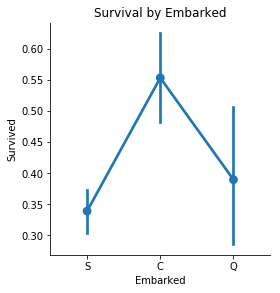

In [11]:
sns.factorplot('Embarked','Survived', data=train_df,size=4)
plt.title("Survival by Embarked")
plt.show()

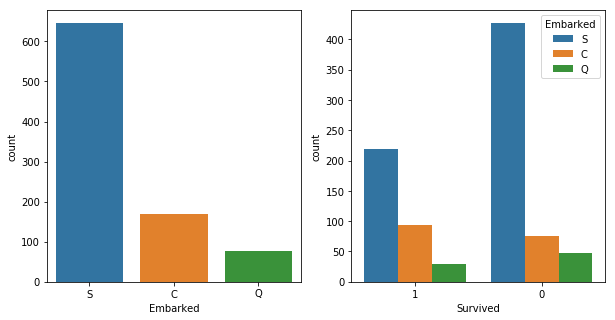

In [12]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0], ax=axis2)
plt.show()

Next we look at how survival varies by the number of Parents/Children and Siblings/Spouses the passenger had onboard. Somewhat unexpectedly, having alot of family members on board makes one much less likely to survive.

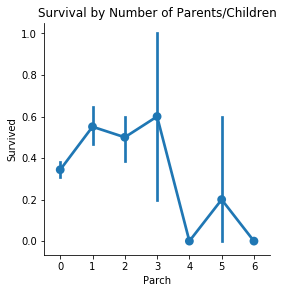

In [13]:
sns.factorplot('Parch','Survived', data=train_df,size=4)
plt.title("Survival by Number of Parents/Children")
plt.show()

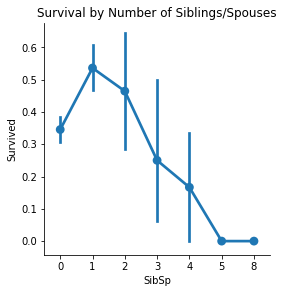

In [14]:
sns.factorplot('SibSp','Survived', data=train_df,size=4)
plt.title("Survival by Number of Siblings/Spouses")
plt.show()

Inspired by how Omar El Gabry dealt with the issue of missing values for age, we follow his general setup with some modifications. The basic idea is to fill in the missing age values with random ages within one standard deviation (to each side) of the average age. Of course, we only want to use the averages and standard deviations from our train dataset. After generating these age values, we compare the distributions before and after to make sure we didn't do anything crazy. The distriutions look very similar, which is comforting.

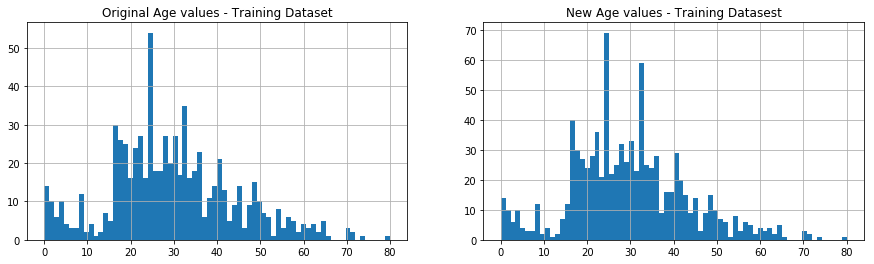

In [15]:

# We get average, std, and number of NaN values in train_df as well as NaN values in test_df
average_age_train   = train_df["Age"].mean()
std_age_train       = train_df["Age"].std()
count_nan_age_train = train_df["Age"].isnull().sum()
count_nan_age_test = test_df["Age"].isnull().sum()

# We generate random numbers between (mean - std) & (mean + std) that we will use to fill in missing values for age.
# Note that we generate two vectors (one for each df) with the only difference being the size.
rand_1 = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = count_nan_age_train)
rand_2 = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = count_nan_age_test)

#Create a plot to compare the age distribution before and after generating our random ages and converting to ints.
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Training Dataset')
axis2.set_title('New Age values - Training Datasest')

# plot original Age values
train_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_df["Age"][np.isnan(train_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

# plot new Age Values
train_df['Age'].hist(bins=70, ax=axis2)
plt.show()

This figure helps us see that children were much more likely to survive than those who were older.

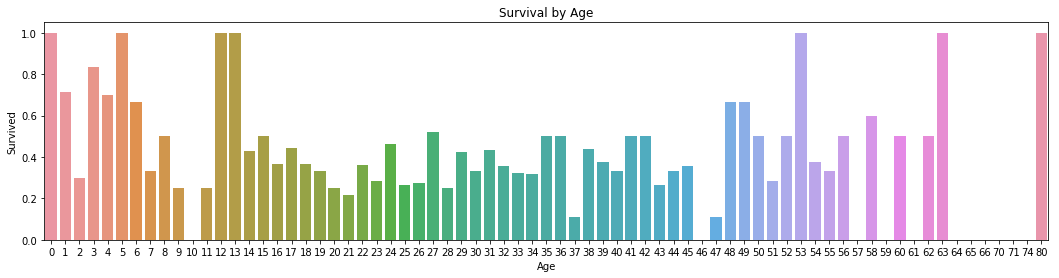

In [16]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)
year = pd.Series(train_df['Age'])
plt.title("Survival by Age")
plt.show()

### More Data Prep
We get dummies for our categorical variables, making sure to drop one of the categories to avoid the dummy trap.

In [17]:
# Dummies for class
pclass_dummies_train = pd.get_dummies(train_df['Pclass'])
pclass_dummies_train.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_train.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

# We drop Pclass now that we have the dummies
train_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

train_df = train_df.join(pclass_dummies_train)
test_df = test_df.join(pclass_dummies_test)

In [18]:
# We do the same thing for Embarked
embark_dummies_train = pd.get_dummies(train_df['Embarked'])
embark_dummies_train.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummies_train)
test_df = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

In [19]:
# And for Sex
sex_dummies_train = pd.get_dummies(train_df['Sex'])
sex_dummies_train.drop(['male'], axis=1, inplace=True)

sex_dummies_test = pd.get_dummies(test_df['Sex'])
sex_dummies_test.drop(['male'], axis=1, inplace=True)

train_df = train_df.join(sex_dummies_train)
test_df = test_df.join(sex_dummies_test)

train_df.drop(['Sex'], axis=1,inplace=True)
test_df.drop(['Sex'], axis=1,inplace=True)

We drop a few variables that we won't be using in our analysis. We keep PassengerID with test_df so we can use it for submitting our predictions later.

In [20]:
train_df = train_df.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Name','Ticket', 'Cabin'], axis=1)

Finally, we note that we do not scale our data since Fare and Age have roughly the same scale.

## Analysis!!

Now we're ready to make our Xtrain, Ytrain, and Xtest datasets.

In [21]:
# Import metrics
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [22]:
xtrain = train_df.drop("Survived",axis=1)
ytrain = train_df["Survived"]
xtest = test_df.drop("PassengerId",axis=1).copy()

### Logistic Regression
We start things off with a more classic model. We first run the logistic regression over a gridsearch based on the f1 score.

In [42]:
logreg = LogisticRegression()
gridsearch = GridSearchCV(logreg, {'penalty': ['l1', 'l2'], 'C': [.1, 1, 10]},
                            scoring="f1", cv=5)
gridsearch.fit(xtrain, ytrain)
print("F1 of Logistic Regression is: ")
print(gridsearch.score(xtrain, ytrain))
print("Where the best parameters are: ")
print(gridsearch.best_params_)

print("Test Classification Report:")
y_pred_train = gridsearch.predict(xtrain)
print(classification_report(ytrain, y_pred_train))

F1 of Logistic Regression is: 
0.731707317073
Where the best parameters are: 
{'C': 1, 'penalty': 'l2'}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.87      0.84       549
          1       0.76      0.70      0.73       342

avg / total       0.80      0.80      0.80       891



Now we look to see if it changes if we use accuracy as our measure. It does seem to matter. For the accuracy measure, it is better to have significantly lower value for C, the hyperparameter for regularization (lower C means strong regularization).

In [43]:
logreg = LogisticRegression()
gridsearch = GridSearchCV(logreg, {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 2, 5]},
                            scoring="accuracy", cv=5)
gridsearch.fit(xtrain, ytrain)
print("Accuracy of Logistic Regression is: ")
print(gridsearch.score(xtrain, ytrain))
print("Where the best parameters are: ")
print(gridsearch.best_params_)

print("Test Classification Report:")
y_pred_train = gridsearch.predict(xtrain)
print(classification_report(ytrain, y_pred_train))

Accuracy of Logistic Regression is: 
0.802469135802
Where the best parameters are: 
{'C': 1, 'penalty': 'l2'}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.87      0.84       549
          1       0.76      0.70      0.73       342

avg / total       0.80      0.80      0.80       891



Since accuracy is the basis of scoring on Kaggle, we predict based off these parameters and export for submission to Kaggle. For reasons that I don't understand, all of the models that I attempted came back with a score of 0. There is a problem in my building or cleaning, but I can't find it.

In [44]:
logreg.fit(xtrain, ytrain)
logreg_pred = logreg.predict(xtest)
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework4\\LogRegPredictions.csv', logreg_pred)

### K Neighbors Classifier

This model is significantly better than the simpler logistic regression as evidenced by the vastly better scores in precision, recall, and f1.

In [39]:
knc = KNeighborsClassifier()
gridsearch = GridSearchCV(knc, {'n_neighbors': [5, 10, 15, 20, 25], 'p': [1, 2], 'weights': ['uniform', 'distance']}, cv=5)
gridsearch.fit(xtrain, ytrain)
print("Best parameters are: ")
print(gridsearch.best_params_)

print("Test Classification Report:")
y_pred_train = gridsearch.predict(xtrain)
print(classification_report(ytrain, y_pred_train))

Where the best parameters are: 
{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       549
          1       1.00      0.96      0.98       342

avg / total       0.98      0.98      0.98       891



In [40]:
knc.fit(xtrain, ytrain)
knc_pred = knc.predict(xtest)
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework4\\KNCPredictions.csv', knc_pred)

### SVC
This model actually takes too long to be useful for this project. I'm sure it works great for other people.

In [ ]:
lsvc = LinearSVC()
gridsearch = GridSearchCV(lsvc, {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}, scoring="accuracy", cv=3)
gridsearch.fit(xtrain, ytrain)
print("Accuracy of Linear SVC is: ")
print(gridsearch.score(xtrain, ytrain))
print("Where the best parameters are: ")
print(gridsearch.best_params_)

print("Test Classification Report:")
y_pred_train = gridsearch.predict(xtrain)
print(classification_report(ytrain, y_pred_train))

### Random Forest
This is one of the more sophisticated ensambling models that we discussed in class. Oddly, it does not perform as well as the seemingly less sophisticated K Neighbors Classifier.

In [33]:
rfc = RandomForestClassifier(oob_score=True, min_samples_leaf = 10)
gridsearch = GridSearchCV(rfc, {'n_estimators': [100, 1000, 2000], 'max_depth': [1, 5, 10, 15]})
gridsearch.fit(xtrain, ytrain)
print("Best parameters of rfc are: ")
print(gridsearch.best_params_)

print("Test Classification Report:")
y_pred_train = gridsearch.predict(xtrain)
print(classification_report(ytrain, y_pred_train))

Best parameters of rfc are: 
{'max_depth': 10, 'n_estimators': 1000}
Test Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.93      0.88       549
          1       0.86      0.71      0.78       342

avg / total       0.85      0.85      0.84       891



In [34]:
rfc.fit(xtrain, ytrain)
rfc_pred = rfc.predict(xtest)
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework4\\RFCPredictions.csv', rfc_pred)

C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jacob\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


### Gaussian Naive Bayes
We finish things off with some naive Bayes. This model doesn't have any hyper parameters other than priors, which we don't include. This model performs about as well as the logistic regression. Not all that impressive.

In [47]:
gnb = GaussianNB()
gridsearch = GridSearchCV(gnb, {})
gridsearch.fit(xtrain, ytrain)
print("Test Classification Report:")
y_pred_train = gridsearch.predict(xtrain)
print(classification_report(ytrain, y_pred_train))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.83      0.83       549
          1       0.73      0.73      0.73       342

avg / total       0.79      0.79      0.79       891



In [48]:
gnb.fit(xtrain, ytrain)
gnb_pred = gnb.predict(xtest)
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework4\\GNBPredictions.csv', gnb_pred)

## Conclusion

The main lesson I learned from this project is to be careful in preparing datasets. I must have done something wrong to my test dataset because my models got a score of 0 accuracy on Kaggle. Everything seems to make sense to me as I got back through it.

If we look at the CV scores, however, there might be some lessons we can learn. KNeighbors performed much better than I would have expected, given its apparent simplicity. I also learned that SVC and Random Forest take much longer than I imagined they would, limiting their usefulness. Keeping run time in mind is essential (another reason why KNeighbors rocks). Logistic Regression was about as exciting and powerful as it sounds like it would be.

I conclude that I would not give any of these models to Zillow since I don't think they care about who survives the Titanic. Instead I would direct them to my work on housing prices in Ames, Iowa.